# Claira Project: Mortgage Contracts

## Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import numpy as np
import gzip
import seaborn as sns
np.random.seed(99)
RANDOM_STATE = 99
import datetime
pd.set_option('display.max_rows', 151)


# Import vectorizing and modeling tools in preparation for modeling steps
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text, stop_words
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
import time

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import spacy
import en_core_web_lg
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Import Data

In [2]:
# Import the CSV file
# raw_df = pd.read_csv('../data/sasb_cash_trap_triggers.csv')

In [3]:
# Import the CSV file
raw_df = pd.read_csv('../data/sasb_cash_trap_triggers_06_09_20.csv')

In [4]:
# Review the first few rows of the data set
raw_df.head()

,Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0


In [5]:
# Check size of the data set
raw_df.shape

(2247, 4)

In [6]:
raw_df = raw_df[['Document', 'Sentence', 'Trigger', 'Multiclass']]

In [7]:
# Check for null values
raw_df.isnull().sum()

Document      0
Sentence      0
Trigger       0
Multiclass    0
dtype: int64

In [8]:
raw_df.dropna()
raw_df.shape

(2247, 4)

In [9]:
raw_df.head(11)

,Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0
5,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,Loan Default,0
6,20120828_01Y0R8_Prospectus_CM00000000205875087...,So long as no Trigger Period or Event of Defau...,Loan Default,0
7,20120828_01Y0R8_Prospectus_CM00000000205875087...,During the continuance of a Trigger Period or ...,Loan Default,0
8,20120828_01Y0R8_Prospectus_CM00000000205875087...,“Trigger Period” means any period that the deb...,DSCR Fall,0
9,20120828_01Y0R8_Prospectus_CM00000000205875087...,"During the continuance of a Trigger Period, th...",Loan Default,0


## Data Cleaning

In [10]:
# Review number of Trigger types
raw_df['Trigger'].value_counts()

nontrigger                   1056
Unspecified                   356
Loan Default                  335
Debt Yield Fall               124
Loan default                   75
Mezzanine Default              57
Bankruptcy                     43
Tenant Failure                 37
Debt yield fall                34
Renovations                    24
DSCR Fall                      19
Operator Termination           19
Sponsor Termination            14
Aggregate Debt Yield Fall      11
Mezzanine Outstanding          10
SFF                             9
Mezzanine default               8
Aggregate debt yield fall       6
Aggregate DSCR Fall             5
Debt Yield Falll                4
Aggregate debt yield            1
Name: Trigger, dtype: int64

In [11]:
# Convert each category to Title format (to remove discrepancies based on capitalization)
raw_df['Trigger'] = raw_df['Trigger'].str.title()

In [12]:
raw_df['Trigger'] = raw_df['Trigger'].str.replace('Falll', 'Fall')

In [13]:
raw_df.loc[raw_df['Trigger'] == 'Aggregate Debt Yield', 'Trigger'] = 'Aggregate Debt Yield Fall'

In [14]:
raw_df['Sentence'] = raw_df['Sentence'].replace({'\$':''}, regex = True)

In [15]:
# Review clean Trigger Types
raw_df['Trigger'].value_counts()

Nontrigger                   1056
Loan Default                  410
Unspecified                   356
Debt Yield Fall               162
Mezzanine Default              65
Bankruptcy                     43
Tenant Failure                 37
Renovations                    24
Dscr Fall                      19
Operator Termination           19
Aggregate Debt Yield Fall      18
Sponsor Termination            14
Mezzanine Outstanding          10
Sff                             9
Aggregate Dscr Fall             5
Name: Trigger, dtype: int64

In [16]:
# Rename first column (document title)
# raw_df = raw_df.rename(columns = {'0': 'Document'})

In [17]:
# Drop Multiclass column for now 
raw_df = raw_df.drop('Multiclass', axis = 1)


In [18]:
raw_df.shape

(2247, 3)

In [19]:
# Count the number of distinct documents
num_docs = raw_df['Document'].nunique()
print(f'{num_docs} unique documents have been included in the data set')

27 unique documents have been included in the data set


In [20]:
# Review the distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf    176
20190220_02IPLU_Prospectus_SD000000002587491183.pdf    138
20190220_02IUQ7_Prospectus_SD000000002587520085.pdf    135
20160510_02B0XU_Prospectus_SD000000002312723382.pdf    125
20190108_02IFF1_Prospectus_SD000000002570458466.pdf    118
20190131_02IFCW_Prospectus_SD000000002578232050.pdf    114
20190131_02IFDN_Prospectus_SD000000002578234912.pdf    112
20190131_02IFE7_Prospectus_SD000000002578234792.pdf    111
20190208_02IM7M_Prospectus_SD000000002581684036.pdf    109
20190220_02IUQG_Prospectus_SD000000002587491537.pdf    100
20190205_02IJ77_Prospectus_SD000000002579874729.pdf     99
20170616_02DNAM_Prospectus_SD000000002355931744.pdf     84
20180125_02FE6L_Prospectus_SD000000002394837596.pdf     82
20170814_02E227_Prospectus_SD000000002367167139.pdf     82
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf     76
20170727_02DTVX_Prospectus_SD000000002362015714.pdf     75
20170525_02DFUI_Prospectus_SD000000002352389122.pdf     

In [21]:
# Summarize the trigger counts for the existing Document set
max_triggers = raw_df['Document'].value_counts().max()
min_triggers = raw_df['Document'].value_counts().min()
print(f'The {num_docs} Documents have tag counts that range from {min_triggers} to {max_triggers}.')

The 27 Documents have tag counts that range from 25 to 176.


In [22]:
# Check for duplicate rows
raw_df['is_duplicate'] = raw_df.duplicated(subset = None)
raw_df['is_duplicate'].value_counts()

False    2174
True       73
Name: is_duplicate, dtype: int64

In [23]:
num_duplicated_rows = (raw_df['is_duplicate'] == True).sum()
print(f'There are {num_duplicated_rows} row duplicates in the data set.')

There are 73 row duplicates in the data set.


In [24]:
# This removes duplicate rows, but those rows are in fact legitimate in the document
raw_df = raw_df.drop('is_duplicate', axis = 1)
raw_df = raw_df.drop_duplicates()

In [25]:
raw_df.shape

(2174, 3)

In [26]:
raw_df.head()

,Document,Sentence,Trigger
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate Dscr Fall
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default


In [27]:
# Review new number of Trigger types
raw_df['Trigger'].value_counts()

Nontrigger                   1030
Loan Default                  400
Unspecified                   346
Debt Yield Fall               147
Mezzanine Default              61
Bankruptcy                     40
Tenant Failure                 37
Renovations                    24
Dscr Fall                      18
Aggregate Debt Yield Fall      18
Operator Termination           17
Sponsor Termination            14
Sff                             9
Mezzanine Outstanding           8
Aggregate Dscr Fall             5
Name: Trigger, dtype: int64

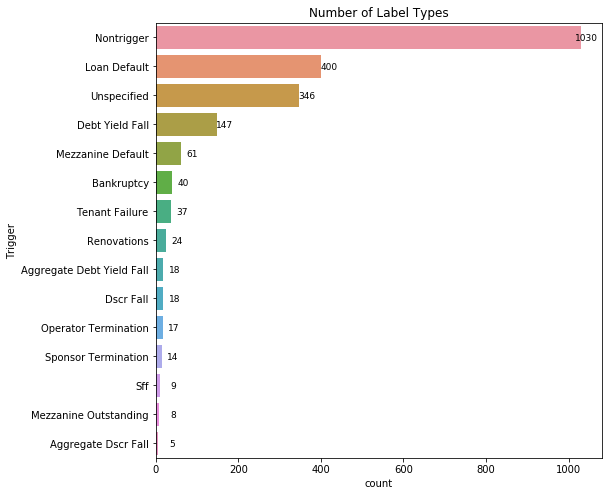

In [28]:
trigger_order = raw_df['Trigger'].value_counts().sort_values(ascending = False).index

fig = plt.gcf()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=raw_df['Trigger'], data=raw_df, orient = 'h', order = trigger_order)
ax.set_title('Number of Label Types');

for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(17, -15),fontsize=9,textcoords='offset points', horizontalalignment='right')
    
#https://stackoverflow.com/questions/50190409/how-to-annotate-horizontal-seaborn-countplots

In [29]:
# Review new distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf    176
20190220_02IPLU_Prospectus_SD000000002587491183.pdf    133
20190220_02IUQ7_Prospectus_SD000000002587520085.pdf    130
20160510_02B0XU_Prospectus_SD000000002312723382.pdf    117
20190131_02IFCW_Prospectus_SD000000002578232050.pdf    114
20190131_02IFDN_Prospectus_SD000000002578234912.pdf    112
20190131_02IFE7_Prospectus_SD000000002578234792.pdf    111
20190208_02IM7M_Prospectus_SD000000002581684036.pdf    109
20190108_02IFF1_Prospectus_SD000000002570458466.pdf    109
20190205_02IJ77_Prospectus_SD000000002579874729.pdf     99
20190220_02IUQG_Prospectus_SD000000002587491537.pdf     95
20170616_02DNAM_Prospectus_SD000000002355931744.pdf     84
20170814_02E227_Prospectus_SD000000002367167139.pdf     77
20180125_02FE6L_Prospectus_SD000000002394837596.pdf     71
20170727_02DTVX_Prospectus_SD000000002362015714.pdf     69
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf     68
20170801_02DX5C_Prospectus_SD000000002363000910.pdf     

In [30]:
raw_df.dtypes

Document    object
Sentence    object
Trigger     object
dtype: object

## Reshape the Data

In this section, we'll reshape the data, such that each sentence is represented once, with separate categorization columns for each Trigger type

In [31]:
# function to reshape the dataframe such that the triggers are 0/1 columns. Remove duplicates
def reshape_trigger_representation(dataframe):
    # select trigger types
    trigger_types = list(dataframe['Trigger'].unique())
    trigger_types = [x for x in trigger_types if str(x) != 'nan']
    
    # create new dataframe with unique document-sentence pairs (no duplicates)
    reshaped = dataframe.drop('Trigger', axis = 1).drop_duplicates().reset_index().drop('index', axis = 1)
    
    # select rows by trigger, reassign as 1 or 0 (for True or False)
    for tt in trigger_types:
        # select part that is trigger_type
        temp = dataframe.loc[dataframe['Trigger'] == tt].copy()

        # create a new column of true with trigger name
        temp[tt.lower().replace(' ', '_')] = np.int64(1)
        temp.drop('Trigger', axis=1, inplace=True)
        temp[tt.lower().replace(' ', '_')] = temp[tt.lower().replace(' ', '_')].astype('Int64')
        
        # left join this adjusted column to the unique data
        reshaped = reshaped.merge(temp, how='left', left_on=['Document', 'Sentence'], right_on=['Document', 'Sentence'])

    # replace nulls with False
    reshaped = reshaped.fillna(0)    
    
    return reshaped

In [32]:
# Reshape our original dataframe
df = reshape_trigger_representation(raw_df)

In [33]:
df.head(5)

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
# Export reshaped to CSV file
#df.to_csv('../data/reshaped_06_04_20.csv')

In [35]:
# Create a dataframe showing the document tagging details (removing sentence details)
doc_view = df.groupby('Document').sum()


In [36]:
doc_view['sum'] = doc_view.sum(axis = 1)
doc_view

,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,sum
Document,,,,,,,,,,,,,,,,
20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,17,1,2,0,0,0,0,0,0,0,0,0,0,43,0,63.0
20150307_028S2X_Prospectus_SD000000002389024187.pdf,15,0,4,10,0,0,0,0,0,0,0,0,0,27,0,56.0
20160310_02AQCW_Prospectus_SD0000000-2003264558.pdf,7,0,0,6,5,3,2,2,0,0,0,0,0,0,0,25.0
20160510_02B0XU_Prospectus_SD000000002312723382.pdf,11,0,3,5,0,0,3,0,4,15,0,0,0,76,0,117.0
20170525_02DFUI_Prospectus_SD000000002352389122.pdf,12,0,7,6,0,0,4,0,4,0,0,0,0,29,0,62.0
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf,18,0,0,8,7,0,0,0,0,0,2,0,0,33,0,68.0
20170616_02DNAM_Prospectus_SD000000002355931744.pdf,12,1,1,7,0,0,7,0,0,0,0,0,0,56,0,84.0
20170727_02DTVX_Prospectus_SD000000002362015714.pdf,19,0,0,8,2,0,0,0,0,0,0,0,0,40,0,69.0
20170801_02DX5C_Prospectus_SD000000002363000910.pdf,5,0,0,16,6,0,0,0,0,0,0,0,0,37,0,64.0


In [37]:
# Export reshaped to CSV file
# doc_view.to_csv('../data/exported_data/doc_view_06_09_20.csv')

In [38]:
# Isolate documents that don't have any Trigger tags (only nontriggers)
no_trigger_tags = list(doc_view.loc[doc_view['sum'] == doc_view['nontrigger']].index)
no_trigger_tags # Save document names to a list

[]

In [39]:
# we will remove any documents that have 0 Cash Trap Trigger clauses within the data set

to_remove = df[df['Document'].isin(no_trigger_tags)]
df = df.drop(to_remove.index)

In [40]:
df.shape

(1933, 17)

## Feature Engineering

In [41]:
# Create a column with length of Sentence
df['sentence_char_count'] = df['Sentence'].str.len()

In [42]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,sentence_char_count
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,446
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,837
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1766
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,302
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,235


## Natural Language Processing of the sentence column

In [43]:
nlp = spacy.load('en_core_web_sm', disable = 'parser')

In [44]:
# Review a tokenized sample Sentence
[token.text for token in nlp(df['Sentence'][2])]

['During',
 'a',
 'Trigger',
 'Period',
 'or',
 'while',
 'an',
 'event',
 'of',
 'default',
 'under',
 'the',
 'Mortgage',
 'Loan',
 'is',
 'continuing',
 ',',
 'all',
 'amounts',
 'available',
 'in',
 'the',
 'Cash',
 'Management',
 'Account',
 'will',
 'be',
 'applied',
 'on',
 'each',
 'Loan',
 'Payment',
 'Date',
 'in',
 'the',
 'following',
 'order',
 'of',
 'priority',
 ':',
 '(',
 'i',
 ')',
 'to',
 'the',
 'Tax',
 'and',
 'Insurance',
 'Reserve',
 'Account',
 ',',
 '(',
 'a',
 ')',
 '1/12th',
 'of',
 'projected',
 'annual',
 'taxes',
 'and',
 '(',
 'b',
 ')',
 '1/12th',
 'of',
 'projected',
 'annual',
 'insurance',
 'premiums',
 '(',
 'unless',
 'certain',
 'blanket',
 'policies',
 'are',
 'in',
 'effect',
 ')',
 ',',
 '(',
 'ii',
 ')',
 'to',
 'the',
 'lender',
 ',',
 'the',
 'amount',
 'of',
 'all',
 'scheduled',
 'or',
 'delinquent',
 'interest',
 'and',
 'principal',
 'on',
 'the',
 'Mortgage',
 'Loan',
 'and',
 'all',
 'other',
 'amounts',
 'then',
 'due',
 'and',
 'payab

In [45]:
# Review a lemmatized sample Sentence
[token.lemma_ for token in nlp(df['Sentence'][2])]

['during',
 'a',
 'trigger',
 'period',
 'or',
 'while',
 'an',
 'event',
 'of',
 'default',
 'under',
 'the',
 'mortgage',
 'loan',
 'be',
 'continue',
 ',',
 'all',
 'amount',
 'available',
 'in',
 'the',
 'cash',
 'management',
 'account',
 'will',
 'be',
 'apply',
 'on',
 'each',
 'loan',
 'payment',
 'date',
 'in',
 'the',
 'follow',
 'order',
 'of',
 'priority',
 ':',
 '(',
 'i',
 ')',
 'to',
 'the',
 'tax',
 'and',
 'insurance',
 'reserve',
 'account',
 ',',
 '(',
 'a',
 ')',
 '1/12th',
 'of',
 'project',
 'annual',
 'tax',
 'and',
 '(',
 'b',
 ')',
 '1/12th',
 'of',
 'project',
 'annual',
 'insurance',
 'premium',
 '(',
 'unless',
 'certain',
 'blanket',
 'policy',
 'be',
 'in',
 'effect',
 ')',
 ',',
 '(',
 'ii',
 ')',
 'to',
 'the',
 'lender',
 ',',
 'the',
 'amount',
 'of',
 'all',
 'schedule',
 'or',
 'delinquent',
 'interest',
 'and',
 'principal',
 'on',
 'the',
 'mortgage',
 'loan',
 'and',
 'all',
 'other',
 'amount',
 'then',
 'due',
 'and',
 'payable',
 'under',
 'the

In [46]:
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return ' '.join(tokens)

df['SentenceTokens'] = df['Sentence'].apply(tokenize)

In [47]:
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

df['SentenceLemmas'] = df['Sentence'].apply(lemmatize)

In [48]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,sentence_char_count,SentenceTokens,SentenceLemmas
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,446,"On each Business Day , the financial instituti...","on each business day , the financial instituti..."
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,837,The Borrower has established and is required t...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1766,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,302,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,235,Available funds in each Cash Management Accoun...,available fund in each cash management account...


In [49]:
# Put all sentences into a list of review tokens
all_sentence_tokens = ' '.join(df['SentenceTokens'])
all_sentence_tokens[:75]

'On each Business Day , the financial institution maintaining the blocked ac'

In [50]:
# Put all sentences into a list of review lemmas
all_sentence_lemmas = ' '.join(df['SentenceLemmas'])
all_sentence_lemmas[:75]

'on each business day , the financial institution maintain the block account'

In [51]:
sentence_token_list = [token for token in all_sentence_tokens.split(' ')]
sentence_lemma_list = [lemma for lemma in all_sentence_lemmas.split(' ')]

In [52]:
token_df = pd.Series(sentence_token_list)
lemma_df = pd.Series(sentence_lemma_list)

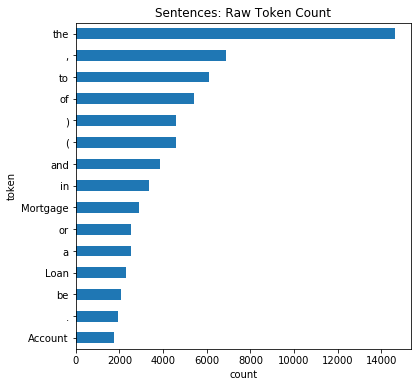

In [53]:
# Plotting the raw token count
token_series = token_df.value_counts().head(15).sort_values(ascending = True)
ax = token_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('token')
ax.set_title('Sentences: Raw Token Count');

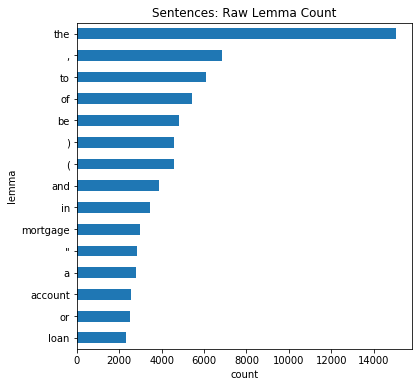

In [54]:
# Plotting the raw lemma count
lemma_series = lemma_df.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Raw Lemma Count');

In [55]:
# Remove punctuation, maintain letters and numbers
df['SentenceLemmas_nopunc'] = df['SentenceLemmas'].str.replace("[^a-zA-Z0-9#']", " ")

In [56]:
# Put all SentenceLemmas_nopunc into a list
all_lemmas_nopunc = ' '.join(df['SentenceLemmas_nopunc'])
lemma_list_nopunc = [lemma for lemma in all_lemmas_nopunc.split(' ')]
lemma_list_nopunc = [lemma for lemma in lemma_list_nopunc if lemma not in ['']]
lemma_list_nopunc[:10]

['on',
 'each',
 'business',
 'day',
 'the',
 'financial',
 'institution',
 'maintain',
 'the',
 'block']

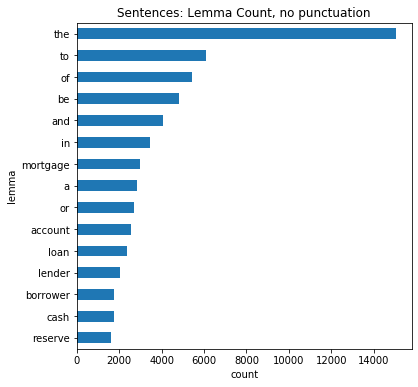

In [57]:
# Create a data series containing the list of words
lemma_df_nopunc = pd.Series(lemma_list_nopunc)
lemma_series_nopunc = lemma_df_nopunc.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series_nopunc.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Lemma Count, no punctuation');

In [58]:
df['SentenceLemmas_nopunc'].head()

0    on each business day   the financial instituti...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

In [59]:
df['SentenceLemmas_nopunc'] = df['SentenceLemmas_nopunc'].str.replace('\s{2,}', ' ')

In [60]:
df['SentenceLemmas_nopunc'].head()

0    on each business day the financial institution...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

## Preprocessing and Preparation for Modeling

In [61]:
short_stopwords = ['the', 'to', 'of', 'be', 'and', 'in', 'a']
short_stopwords2 = ['the', 'and', 'a', 'to', 'it', 'be', 'for', 'with', 'that']

In [62]:
# Look at original stopword list
stopwords = list(STOP_WORDS)
stopwords

['four',
 'these',
 'had',
 'hereafter',
 'we',
 'without',
 'has',
 'thereby',
 'be',
 'empty',
 'to',
 'which',
 'eleven',
 'everything',
 'ours',
 'see',
 'such',
 'made',
 'onto',
 'few',
 'therein',
 'by',
 'have',
 'above',
 'whither',
 'ever',
 'he',
 'i',
 'hereupon',
 'show',
 'anyhow',
 'nobody',
 'regarding',
 'wherever',
 'who',
 'three',
 'how',
 'five',
 'are',
 'himself',
 'when',
 'into',
 'along',
 'or',
 'although',
 'former',
 'since',
 'why',
 'behind',
 'say',
 're',
 'those',
 'no',
 'anything',
 'one',
 'my',
 'a',
 'back',
 'may',
 'then',
 'must',
 'upon',
 'within',
 'wherein',
 'will',
 'if',
 'its',
 'over',
 'under',
 'whom',
 'became',
 'neither',
 'however',
 'nowhere',
 'due',
 'amongst',
 'too',
 'therefore',
 'would',
 'around',
 'among',
 'across',
 'at',
 'does',
 'fifteen',
 'further',
 'cannot',
 'done',
 'keep',
 'latter',
 'latterly',
 'mine',
 'something',
 'somewhere',
 'from',
 'other',
 'some',
 'even',
 'six',
 'the',
 'becomes',
 'toward',


## Train/Test Split

In [63]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,...,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,sentence_char_count,SentenceTokens,SentenceLemmas,SentenceLemmas_nopunc
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,446,"On each Business Day , the financial instituti...","on each business day , the financial instituti...",on each business day the financial institution...
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,837,The Borrower has established and is required t...,the borrower have establish and be require to ...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1766,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,302,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,235,Available funds in each Cash Management Accoun...,available fund in each cash management account...,available fund in each cash management account...


In [64]:
# Start by predicting Loan Default trigger

target = 'nontrigger'


X = df['SentenceLemmas']
y = df[target]
indices = df.index

y = y.astype('int')

In [65]:
y.dtypes

dtype('int64')

In [66]:
# Checking shape of X and y 
print(f'X shape is {X.shape}')
print(f'y shape is {y.shape}')

X shape is (1933,)
y shape is (1933,)


In [67]:
y.value_counts()

1    1030
0     903
Name: nontrigger, dtype: int64

In [68]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size = 0.3, stratify = y, random_state = RANDOM_STATE)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(indices_train.shape, indices_test.shape)

(1353,) (1353,)
(580,) (580,)
(1353,) (580,)


In [69]:
X.head()

0    on each business day , the financial instituti...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas, dtype: object

In [70]:
X_train.shape[0]

1353

In [71]:
y_train.shape[0]

1353

## Modeling

### CountVectorizer + Logistic Regression GridSearch and modeling

In [72]:
# Define CVEC + Logistic Regression Pipeline
pipe_cvec = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression(solver = 'liblinear', random_state = RANDOM_STATE))])
cvec_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8)],
    'cvec__stop_words': [None, short_stopwords, short_stopwords2, stopwords],  
    'cvec__max_features': [100, 200, 400, 600, 1000],
    'cvec__min_df': [2],
    'cvec__max_df': [.99],
    }

gs_cvec = GridSearchCV(pipe_cvec, param_grid = cvec_params, cv = 3, scoring = 'f1')

# Start the timer.
t0 = time.time()

results_cvec = gs_cvec.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



Seconds elapsed for fitting: 218.816


In [73]:
t0 = time.time()
print(f'Training score is {results_cvec.score(X_train, y_train):.3f}')
print(f'Test score is {results_cvec.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_cvec.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.994
Test score is 0.976
Cross Validation score is 0.953
Seconds elapsed for score calculation: 1.068


In [74]:
print(f'Best Score:{(results_cvec.best_score_):.3f}')
print(f'Best Parameters :{results_cvec.best_params_}')

Best Score:0.974
Best Parameters :{'cvec__max_df': 0.99, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': ['four', 'these', 'had', 'hereafter', 'we', 'without', 'has', 'thereby', 'be', 'empty', 'to', 'which', 'eleven', 'everything', 'ours', 'see', 'such', 'made', 'onto', 'few', 'therein', 'by', 'have', 'above', 'whither', 'ever', 'he', 'i', 'hereupon', 'show', 'anyhow', 'nobody', 'regarding', 'wherever', 'who', 'three', 'how', 'five', 'are', 'himself', 'when', 'into', 'along', 'or', 'although', 'former', 'since', 'why', 'behind', 'say', 're', 'those', 'no', 'anything', 'one', 'my', 'a', 'back', 'may', 'then', 'must', 'upon', 'within', 'wherein', 'will', 'if', 'its', 'over', 'under', 'whom', 'became', 'neither', 'however', 'nowhere', 'due', 'amongst', 'too', 'therefore', 'would', 'around', 'among', 'across', 'at', 'does', 'fifteen', 'further', 'cannot', 'done', 'keep', 'latter', 'latterly', 'mine', 'something', 'somewhere', 'from', 'other',

### 5: CountVectorizor + Random Forest

In [75]:
'''
# Define CVEC + Logistic Regression Pipeline
pipe_rf = Pipeline([('cvec', CountVectorizer()), ('rf', RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = 2))])
rf_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5)],
    'cvec__stop_words': [None, short_stopwords, short_stopwords2],  
    'cvec__max_features': [100, 200, 400, 800],
    'cvec__min_df': [2],
    'cvec__max_df': [.99],
    'rf__max_depth': [4,5, 6],
    'rf__min_samples_split': [2,3],
    'rf__min_samples_leaf': [10, 12]
    }

gs_rf = GridSearchCV(pipe_rf, param_grid = rf_params, cv = 3, scoring = 'f1')

# Start the timer.
t0 = time.time()

results_rf = gs_rf.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.

'''

"\n# Define CVEC + Logistic Regression Pipeline\npipe_rf = Pipeline([('cvec', CountVectorizer()), ('rf', RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = 2))])\nrf_params = {\n    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5)],\n    'cvec__stop_words': [None, short_stopwords, short_stopwords2],  \n    'cvec__max_features': [100, 200, 400, 800],\n    'cvec__min_df': [2],\n    'cvec__max_df': [.99],\n    'rf__max_depth': [4,5, 6],\n    'rf__min_samples_split': [2,3],\n    'rf__min_samples_leaf': [10, 12]\n    }\n\ngs_rf = GridSearchCV(pipe_rf, param_grid = rf_params, cv = 3, scoring = 'f1')\n\n# Start the timer.\nt0 = time.time()\n\nresults_rf = gs_rf.fit(X_train, y_train)\n\nprint(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.\n\n"

In [76]:
'''
t0 = time.time()
print(f'Training score is {results_rf.score(X_train, y_train):.3f}')
print(f'Test score is {results_rf.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_rf.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.
'''

"\nt0 = time.time()\nprint(f'Training score is {results_rf.score(X_train, y_train):.3f}')\nprint(f'Test score is {results_rf.score(X_test, y_test):.3f}')\nprint(f'Cross Validation score is {cross_val_score(results_rf.best_estimator_, X, y, cv = 3).mean():.3f}')\nprint(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.\n"

In [77]:
'''
print(f'Best Score: {results_rf.best_score_}')
print(f'Best Parameters: {results_rf.best_params_}')
'''

"\nprint(f'Best Score: {results_rf.best_score_}')\nprint(f'Best Parameters: {results_rf.best_params_}')\n"

## Model Selection
- In this section we compare the Train and Test scores across the various models

In [78]:
# Check Training Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_train, y_train):.3f}')
# print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_train, y_train):.3f}')
# print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_train, y_train):.3f}')
# print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_train, y_train):.3f}')
# print(f'CountVectorizer + Random Forest Accuracy:      {results_rf.score(X_train, y_train):.3f}')

Baseline Score:                                0.467
CountVectorizer + LogisticRegression Accuracy: 0.994


In [79]:
# Check Testing Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_test, y_test):.3f}')
# print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_test, y_test):.3f}')
# print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_test, y_test):.3f}')
# print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_test, y_test):.3f}')
# print(f'CountVectorizer + Random Forest Accuracy:      {results_rf.score(X_test, y_test):.3f}')

Baseline Score:                                0.467
CountVectorizer + LogisticRegression Accuracy: 0.976


## Model Evaluation - Logistic Regression

In [80]:
# Isolate the individual words and their coefficients
# Feature names (i.e., words in the Sentences):
names = results_cvec.best_estimator_.steps[0][1].get_feature_names()

# classifier (betas):
classifier = results_cvec.best_estimator_.named_steps['lr']

# https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn

In [81]:
# Extract coefficients from the classifier defined above
coef_cvec = np.array(classifier.coef_).tolist()[0]
coef_cvec[:10] #Look at 10 coefficients

[-0.17528206030152904,
 0.25136364519785837,
 0.18220860441857412,
 0.16979469863062618,
 0.1493915494685445,
 0.20970450267877888,
 0.24408906786706372,
 -0.004191915511820448,
 0.06460280462302005,
 0.1636636797594337]

In [82]:
# Create zipped list of the word names with their corresponding beta coefficients
cvec_top_words = list(zip(names, coef_cvec))

In [83]:
# Create final dataframe of words with their corresponding coefficients
df_cvec_coefs = pd.DataFrame(cvec_top_words).rename(columns = {0: 'word', 1: 'coef'}).sort_values(by = 'coef', ascending = True)

In [84]:
# Top differentiating words and phrases for this Trigger type
df_cvec_coefs.tail(20).sort_values('coef', ascending = False)

,word,coef
576,marriott,0.702205
791,renovation work replacements,0.656806
759,qualified,0.614773
657,operator,0.607322
457,hotel operator,0.607298
766,reasonable,0.603597
823,require renovation work,0.596354
745,property tax,0.579008
561,management,0.577510
692,perform,0.566843


In [85]:
# Display top opposing words and phrases for this Trigger type
df_cvec_coefs.head(20)

,word,coef
960,trigger,-2.526393
693,period,-1.912713
363,event,-1.607187
962,trigger period,-1.538044
181,cash management period,-1.426504
273,default,-1.357566
365,event default,-1.339575
171,cash,-1.128057
228,continuance,-1.053717
694,period borrower,-0.877896


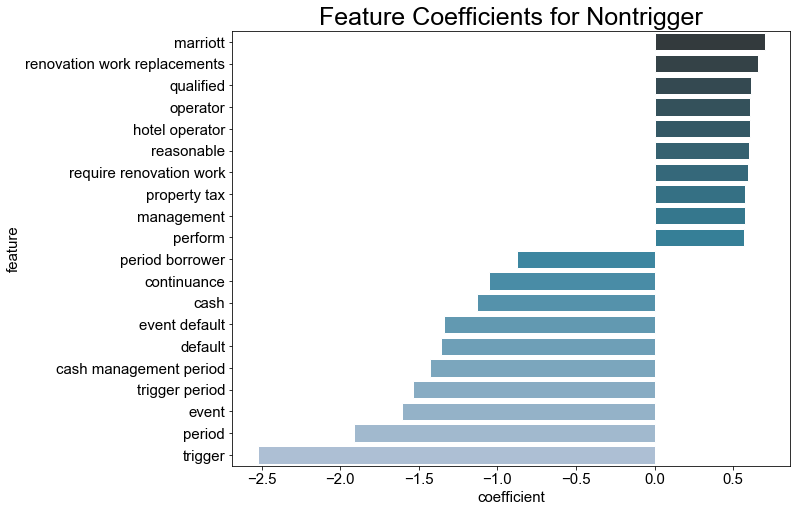

In [86]:
def coef_plot(category):
    '''
    Plots the top 10 and bottom 10 coefficients for the complexity category specified
    '''
    coefs_1 = df_cvec_coefs.sort_values(by=category, ascending=False).tail(10) # getting the top 10 coefficients
    coefs_2 = df_cvec_coefs.sort_values(by=category, ascending=False).head(10) # getting the bottom 10 coefficients
    coefs = pd.concat([coefs_2, coefs_1], axis = 0) # merging the two into one
    # plotting importance
    plt.figure(figsize=(10, 8)) # plotting the coefficients
    plt.title(f'Feature Coefficients for {target.replace("_", " ").title()}', fontsize=25)
    sns.set_style("darkgrid")
    sns.barplot(data=coefs,
                x=category,
                y='word',
                orient='h',
                palette = 'PuBuGn_d')
    plt.xlabel('coefficient', fontsize=15)
    plt.ylabel('feature', fontsize=15)
    plt.tick_params(labelsize=15)
coef_plot('coef')

## Calculating predictions and Confusion Matrix

In [87]:
# Here, we isolate our best model & make predictions based on our test data
best_model = results_cvec.best_estimator_
preds = best_model.predict(X_test)

In [88]:
# Checking our predictions
preds[:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [89]:
## Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test, preds)
print('This is a confusion matrix for our test data vs predictions:')
print(cm_test)

This is a confusion matrix for our test data vs predictions:
[[263   8]
 [  7 302]]


In [90]:
# Converting our confusion matrix into a dataframe
cm_test = pd.DataFrame(cm_test, columns=['Predicted Negative','Predicted Positive'], 
                       index=['Actual Negative','Actual Positive'])

In [91]:
cm_test

,Predicted Negative,Predicted Positive
Actual Negative,263,8
Actual Positive,7,302


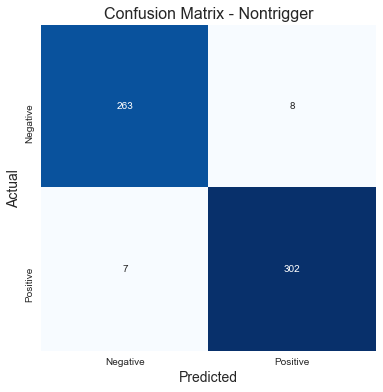

In [92]:
# Plot our confusion matrix
plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm_test, 
            annot=True, 
            ax = ax, 
            fmt='g', 
            cbar=False,
            cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_title(f'Confusion Matrix - {target.replace("_", " ").title()}', size=16)
ax.set_xlabel('Predicted', size=14)
ax.set_ylabel('Actual', size=14)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

In [93]:
# Setting up probabilities for the ROC curve
pred_proba = results_cvec.predict_proba(X_test)
preds = results_cvec.predict(X_test)



In [94]:
# Calculate probabilities
pred_proba = [i[1] for i in results_cvec.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df.shape

(580, 2)

In [95]:
# We establish the probabilities to be used to create the ROC curve
y_pred_proba = results_cvec.predict_proba(X_test)

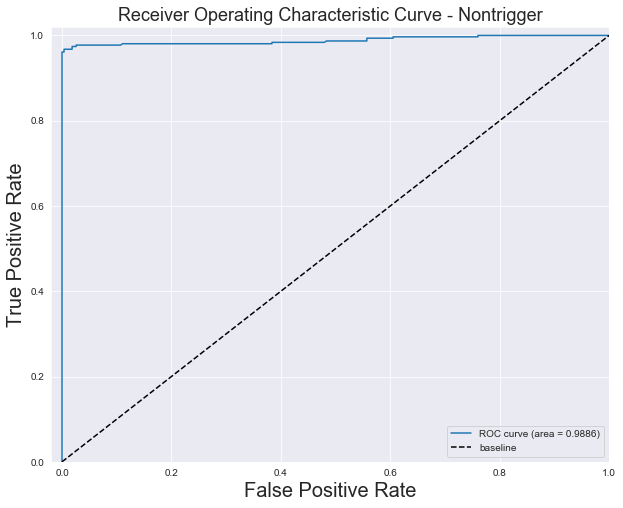

In [96]:
fpr, tpr, _= roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='baseline')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate', fontsize =20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title(f'Receiver Operating Characteristic Curve - {target.replace("_", " ").title()}', fontsize=18)
plt.legend(loc="lower right");

In [98]:
# To allow us to better read the Sentences
pd.set_option('display.max_colwidth', None)

In [99]:
result_cols = ['index', 'prediction', 'actual', 'model_input']
results = pd.DataFrame({'index': list(indices_test),'prediction': list(preds), 'actual': list(y_test), 'model_input': list(X_test)})

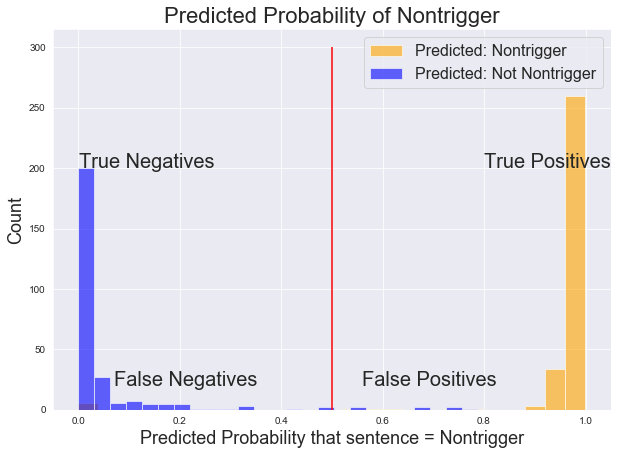

In [120]:
# Histogram overlay for two classes
plt.figure(figsize = (10,7))

# Create two histograms of observations.

plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = f'Predicted: {target.replace("_", " ").title()}')
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = f'Predicted: Not {target.replace("_", " ").title()}')


plt.vlines(x = .5,
           ymin = 0,
           ymax = 300,
           color = 'r',
           linestyle = '-')


# Label axes.
plt.title(f'Predicted Probability of {target.replace("_", " ").title()}', fontsize = 22)
plt.ylabel('Count', fontsize = 18)
plt.xlabel(f'Predicted Probability that sentence = {target.replace("_", " ").title()}', fontsize = 18)

plt.annotate(xy = (0.001, 200), s = 'True Negatives', size = 20)
plt.annotate(xy = (0.07, 20), s = 'False Negatives', size = 20)
plt.annotate(xy = (0.56, 20), s = 'False Positives', size = 20)
plt.annotate(xy = (0.8, 200), s = 'True Positives', size = 20)

# Create legend.
plt.legend(fontsize = 16);

In [101]:
# set index as index column
results.set_index('index', inplace = True)
results.head()

,prediction,actual,model_input
index,,,
1699,1,1,""" ff&e "" mean , collectively , furnishing , fixture and equipment ."
1183,1,1,"the borrower will maintain the cash management account for so long as the debt remain outstanding , which cash management account will be under the sole dominion and control of the lender ( subject to the term of the loan agreement and of the cash management agreement ) ."
995,1,1,there be a risk that the borrowers or a property manager could divert receipt from residential tenant at the properties rather than reserve the amount require under the loan documents .
1266,1,1,"university centre reserve : 2,599,345 be deposit at origination represent 115 % of the total cost budget by the borrower for restoration at university centre due to hurricane florence and 198,676 be deposit for the full amount of the rent payable by affected tenant ."
966,1,1,the borrower will be liable for any deficiency in available fund in the reserve accounts which may be necessary to pay all amount due from time to time under the mortgage loan documents .


In [102]:
misclassified = results[results['prediction'] != results['actual']]


In [103]:
misclassified = misclassified.merge(df, how = 'left', left_index = True, right_index = True)

In [104]:
misclassified = misclassified[['prediction', 'actual', 'model_input', 'Document', 'Sentence',
       'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger', 'sff']]

In [105]:
misclassified.head()

,prediction,actual,model_input,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,,,,
1534,0,1,"upon the first occurrence of a trigger period , the mortgage lender , on borrower ’s behalf , will establish ( i ) an eligible account ( the "" cash management account "" ) with the mortgage lender or servicer , as applicable , in the name of borrower for the sole and exclusive benefit of the mortgage lender , ( ii ) an eligible account into which the amount require for the payment of debt service under the mortgage loan will be deposit ( the "" debt service account "" ) , and ( iii ) an eligible account into which the amount require for the payment of mezzanine debt service under the mezzanine loan will be deposit ( the "" mezzanine debt service account "" ) .",20190208_02IM7M_Prospectus_SD000000002581684036.pdf,"Upon the first occurrence of a Trigger Period, the Mortgage Lender, on Borrower’s behalf, will establish (i) an Eligible Account (the “Cash Management Account”) with the Mortgage Lender or Servicer, as applicable, in the name of Borrower for the sole and exclusive benefit of the Mortgage Lender, (ii) an Eligible Account into which the amounts required for the payment of Debt Service under the Mortgage Loan will be deposited (the “Debt Service Account”), and (iii) an Eligible Account into which the amounts required for the payment of Mezzanine Debt Service under the Mezzanine Loan will be deposited (the “Mezzanine Debt Service Account”).",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
29,1,0,"the borrower be require to deliver to each tenant in the property a write notice instruct that all payment under the lease be to be transmit by -PRON- to a lockbox account ( provide borrower be not require to because sl green management llc , as a tenant at the property , to deposit rent payable by to the borrowers into the lockbox account except during the continuance of an event of default ) .",20150307_028S2X_Prospectus_SD000000002389024187.pdf,"The Borrowers are required to deliver to each tenant in the Property a written notice instructing that all payments under the leases are to be transmitted by them to a Lockbox Account (provided Borrowers are not required to cause SL Green Management LLC , as a tenant at the Property, to deposit rent payable by to the Borrowers into the Lockbox Account except during the continuance of an Event of Default).",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1347,0,1,"mortgage lender will disburse to the borrower the capital expenditures reserve funds upon satisfaction by the borrower of each of the following condition : ( i ) the borrower will submit a request for payment to mortgage lender at least 10 business days prior to the date on which the borrower request such payment be make and specifie the approved capital expenditures to be pay ; ( ii ) on the date such request be receive by mortgage lender and on the date such payment be to be make , no mortgage loan event of default will exist and remain uncured ; ( iii ) mortgage lender will have receive a certificate from the borrower ( a ) state that the item to be fund by the request disbursement be approved capital expenditures , ( b ) state that all approved capital expenditures at the property to be fund by the request disbursement have be complete ( or complete to the extent of the request disbursement ) in a good and workmanlike manner and in accordance with all applicable legal requirements , ( c ) state that each person that supply material or labor in connection with the approved capital expenditures to be fund by the request disbursement have be pay in full for work complete through such date or will be pay in full upon such disbursement ( or if progress payment be be make , that such person have be or will be pay all amount owe to -PRON- base on the wor

In [106]:
# misclassified['prediction'].astype('Int64')
# misclassified['actual'].astype('Int64')

In [107]:
print(f'We incorrectly predicted the trigger type for {misclassified.shape[0]} sentences.')

We incorrectly predicted the trigger type for 15 sentences.


In [108]:
# Show the split of the misclassified predictions
misclassified['prediction'].value_counts()

1    8
0    7
Name: prediction, dtype: int64

## Review the Incorrect Predictions

### Misclassifications: wrongly predicted to be the trigger category

In [109]:
misclassified_as_true = misclassified.loc[misclassified['prediction'] == 1]
misclassified_as_true

,prediction,actual,model_input,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,,,,
29,1,0,"the borrower be require to deliver to each tenant in the property a write notice instruct that all payment under the lease be to be transmit by -PRON- to a lockbox account ( provide borrower be not require to because sl green management llc , as a tenant at the property , to deposit rent payable by to the borrowers into the lockbox account except during the continuance of an event of default ) .",20150307_028S2X_Prospectus_SD000000002389024187.pdf,"The Borrowers are required to deliver to each tenant in the Property a written notice instructing that all payments under the leases are to be transmitted by them to a Lockbox Account (provided Borrowers are not required to cause SL Green Management LLC , as a tenant at the Property, to deposit rent payable by to the Borrowers into the Lockbox Account except during the continuance of an Event of Default).",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
518,1,0,"the borrower be require to deposit into an eligible account hold by mortgage lender or servicer ( the "" leasing reserve account "" ) ( i ) on the origination date , an amount equal to 4,601,434 for approved leasing costs identify in schedule xi attach to the mortgage loan agreement ( the "" closing date approved leasing costs "" ) , ( ii ) on each payment date during a trigger period , an amount equal to 1.25 per rentable square foot per annum at the property ( which , as of the origination date , be 76,915 per month ) ( the "" monthly leasing reserve deposit "" ) , and ( iii ) any amount require to be deposit in the leasing reserve account pursuant to the mortgage loan agreement . amount deposit pursuant to the leasing reserve account be refer to in this paragraph as the "" leasing reserve funds . """,20190131_02IFE7_Prospectus_SD000000002578234792.pdf,"The Borrower is required to deposit into an Eligible Account held by Mortgage Lender or Servicer (the “Leasing Reserve Account”) (i) on the Origination Date, an amount equal to 4,601,434 for Approved Leasing Costs identified in Schedule XI attached to the Mortgage Loan Agreement (the “Closing Date Approved Leasing Costs”), (ii) on each Payment Date during a Trigger Period, an amount equal to 1.25 per rentable square foot per annum at the Property (which, as of the Origination Date, is 76,915 per month) (the “Monthly Leasing Reserve Deposit”), and (iii) any amounts required to be deposited in the Leasing Reserve Account pursuant to the Mortgage Loan Agreement. Amounts deposited pursuant to the leasing reserve account are referred to in this paragraph as the “Leasing Reserve Funds.”",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1789,1,0,"in the event the mortgage lender determine in -PRON- reasonable discretion that any required renovation work or replacement be not be perform in a workmanlike or timely manner or that any required renovation work or replacement have not be complete in a workmanlike or timely manner , and the property manager have indicate in write that such failure to so perform or complete may result in an event of default under the management agreement , upon three business days write notice to the borrower , the mortgage lender will have the option to withhold disbursement for such unsatisfactory require renovation work or replacements until so perform or complete and upon the occurrence and during the continuation of a mortgage loan event of default , to proceed under exist contract or to contract with third party to complete such require renovation work or replacements and if a mortgage loan event of default be continue ( or with respect to the required renovation work , a required renovation default be also continue ) , to apply the required renovation reserve fund and replacem

In [110]:
misclassified_as_true_summary = misclassified_as_true[['prediction', 'actual', 'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger', 'sff']]


In [111]:
misclassified_as_true_count = misclassified_as_true_summary.shape[0]
print(f'{misclassified_as_true_count} sentences were predicted to be the trigger category, but in fact were not this category.')

8 sentences were predicted to be the trigger category, but in fact were not this category.


In [112]:
misclassified_as_true_summary.loc['sum',:] = misclassified_as_true.sum(axis = 0).copy(deep = True)


/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [113]:
misclassified_as_true_summary

,prediction,actual,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,
29,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
518,1.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1789,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
689,1.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
188,1.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
662,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
674,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
297,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
sum,8.0,0.0,4,0,0,2,0,0,0,0,0,0,1,0,3,0,0


### Misclassifications: wrongly predicted NOT to be the trigger category

In [114]:
misclassified_as_false = misclassified.loc[misclassified['prediction'] == 0]
misclassified_as_false

,prediction,actual,model_input,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,,,,
1534,0,1,"upon the first occurrence of a trigger period , the mortgage lender , on borrower ’s behalf , will establish ( i ) an eligible account ( the "" cash management account "" ) with the mortgage lender or servicer , as applicable , in the name of borrower for the sole and exclusive benefit of the mortgage lender , ( ii ) an eligible account into which the amount require for the payment of debt service under the mortgage loan will be deposit ( the "" debt service account "" ) , and ( iii ) an eligible account into which the amount require for the payment of mezzanine debt service under the mezzanine loan will be deposit ( the "" mezzanine debt service account "" ) .",20190208_02IM7M_Prospectus_SD000000002581684036.pdf,"Upon the first occurrence of a Trigger Period, the Mortgage Lender, on Borrower’s behalf, will establish (i) an Eligible Account (the “Cash Management Account”) with the Mortgage Lender or Servicer, as applicable, in the name of Borrower for the sole and exclusive benefit of the Mortgage Lender, (ii) an Eligible Account into which the amounts required for the payment of Debt Service under the Mortgage Loan will be deposited (the “Debt Service Account”), and (iii) an Eligible Account into which the amounts required for the payment of Mezzanine Debt Service under the Mezzanine Loan will be deposited (the “Mezzanine Debt Service Account”).",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1347,0,1,"mortgage lender will disburse to the borrower the capital expenditures reserve funds upon satisfaction by the borrower of each of the following condition : ( i ) the borrower will submit a request for payment to mortgage lender at least 10 business days prior to the date on which the borrower request such payment be make and specifie the approved capital expenditures to be pay ; ( ii ) on the date such request be receive by mortgage lender and on the date such payment be to be make , no mortgage loan event of default will exist and remain uncured ; ( iii ) mortgage lender will have receive a certificate from the borrower ( a ) state that the item to be fund by the request disbursement be approved capital expenditures , ( b ) state that all approved capital expenditures at the property to be fund by the request disbursement have be complete ( or complete to the extent of the request disbursement ) in a good and workmanlike manner and in accordance with all applicable legal requirements , ( c ) state that each person that supply material or labor in connection with the approved capital expenditures to be fund by the request disbursement have be pay in full for work complete through such date or will be pay in full upon such disbursement ( or if progress payment be be make , that such person have be or will be pay all amount owe to -PRON- base on the work such person have complete ) , and ( d ) state that all previous disbursement of capital expenditures reserve funds have be use to pay for the previously identify approved capital expenditures ; ( iv ) at mortgage lender ’s option , if the cost of any individual approved capital expenditure exceed 250,000 , a title search for the property indicate that the property be free from all lien , claim and other encumbrance other than permit encumbrances ; ( v ) if require by mortgage lender if the cost of any individual approved capital expenditure exceed 250,000 , mortgage lender will have verify ( by an inspection conduct at the borrower ’s expense ) performance of the work associate with such approved capital expenditure ; and ( vi ) mortgage lender will have receive such other evidence as mortgage lender will reasonably request that the approved capital expenditures at the property to be fu

In [115]:
misclassified_as_false_summary = misclassified_as_false[['prediction', 'actual', 'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger', 'sff']]


In [116]:
misclassified_as_false_count = misclassified_as_false.shape[0]
print(f'{misclassified_as_false_count} sentences were predicted not to be the trigger category, but in fact were this trigger category.')

7 sentences were predicted not to be the trigger category, but in fact were this trigger category.


In [117]:
misclassified_as_false_summary.loc['sum',:] = misclassified_as_false.sum(axis = 0).copy(deep = True)
misclassified_as_false_summary

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,prediction,actual,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,
1534,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1347,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1494,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
877,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1533,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1667,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1538,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
sum,0.0,7.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0


### Export Misclassification summaries

In [118]:
# Export to CSV file
#misclassified_as_false_summary.to_csv(f'../data/exported_data/{target}_misclassified_as_false_06_09_20.csv')
#misclassified_as_true_summary.to_csv(f'../data/exported_data/{target}_misclassified_as_true_06_09_20.csv')

In [119]:
# Export to CSV fie
#misclassified_as_false.to_csv(f'../data/exported_data/{target}_misclassified_as_false_sentences_06_09_20.csv')
#misclassified_as_true.to_csv(f'../data/exported_data/{target}_misclassified_as_true_sentences_06_09_20.csv')